<a href="https://colab.research.google.com/github/mmontielpz/premier-data-scout/blob/main/atacantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install soccerdata

In [ ]:
import soccerdata as sd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[03/14/25 03:37:18] INFO     No custom team name replacements found. You can configure these in       ]8;id=912224;file:///usr/local/lib/python3.11/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=875941;file:///usr/local/lib/python3.11/dist-packages/soccerdata/_config.py#91\91]8;;\
                             /root/soccerdata/config/teamname_replacements.json.                                   

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=543791;file:///usr/local/lib/python3.11/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=231468;file:///usr/local/lib/python3.11/dist-packages/soccerdata/_config.py#197\197]8;;\
                             /root/soccerdata/config/league_dict.json.                                             

In [ ]:
# Step 1: Initialize FBref for the English Premier League season 2023
fbref = sd.FBref(leagues="ENG-Premier League", seasons=2024)

[03/14/25 03:37:20] INFO     Saving cached data to /root/soccerdata/data/FBref                       ]8;id=508380;file:///usr/local/lib/python3.11/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=830681;file:///usr/local/lib/python3.11/dist-packages/soccerdata/_common.py#263\263]8;;\

In [ ]:
# Step 2: Read player season offensive statistics
player_creation_stats = fbref.read_player_season_stats(stat_type="goal_shot_creation")

                    WARNING  /usr/local/lib/python3.11/dist-packages/soccerdata/fbref.py:165:       ]8;id=885708;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=345399;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                             FutureWarning: The behavior of DataFrame concatenation with empty or                  
                             all-NA entries is deprecated. In a future version, this will no longer                
                             exclude empty or all-NA columns when determining the result dtypes. To                
                             retain the old behavior, exclude the relevant entries before the                      
                             concat operation.                                                                     
                               pd.concat(dfs)                                                                      
                                                                                                                   

In [ ]:
# Step 3: Flatten multi-level columns if necessary
if isinstance(player_creation_stats.columns[0], tuple):
    player_creation_stats.columns = [f"{col1}_{col2}" if col2 else col1
                                     for col1, col2 in player_creation_stats.columns]

In [ ]:
# Step 4: Inspect the available columns
print("Available columns in offensive stats:")
print(player_creation_stats.columns.tolist())

Available columns in offensive stats:
['nation', 'pos', 'age', 'born', '90s', 'SCA_SCA', 'SCA_SCA90', 'SCA Types_PassLive', 'SCA Types_PassDead', 'SCA Types_TO', 'SCA Types_Sh', 'SCA Types_Fld', 'SCA Types_Def', 'GCA_GCA', 'GCA_GCA90', 'GCA Types_PassLive', 'GCA Types_PassDead', 'GCA Types_TO', 'GCA Types_Sh', 'GCA Types_Fld', 'GCA Types_Def']


In [ ]:
# Step 5: Read miscellaneous stats to include performance errors
player_misc_stats = fbref.read_player_season_stats(stat_type="misc")

[03/14/25 03:37:21] WARNING  /usr/local/lib/python3.11/dist-packages/soccerdata/fbref.py:165:       ]8;id=495660;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=880599;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                             FutureWarning: The behavior of DataFrame concatenation with empty or                  
                             all-NA entries is deprecated. In a future version, this will no longer                
                             exclude empty or all-NA columns when determining the result dtypes. To                
                             retain the old behavior, exclude the relevant entries before the                      
                             concat operation.                                                                     
                               pd.concat(dfs)                                                                      
                                                                                                                   

In [ ]:
# Step 6: Flatten and select relevant columns
if isinstance(player_misc_stats.columns[0], tuple):
    player_misc_stats.columns = ["_".join(col).strip() if isinstance(col, tuple) else col for col in player_misc_stats.columns]

# Ensure 'player' column exists before merging
if 'player' not in player_misc_stats.columns:
    player_misc_stats = player_misc_stats.reset_index()

error_columns = ["Performance_CrdY", "Performance_CrdR", "Performance_Fls", "Performance_Off", "Performance_PKcon"]
existing_error_columns = [col for col in error_columns if col in player_misc_stats.columns]

player_misc_stats = player_misc_stats[["player"] + existing_error_columns]

# Convert error columns to numeric values
for col in existing_error_columns:
    player_misc_stats[col] = pd.to_numeric(player_misc_stats[col], errors="coerce").fillna(0)

In [ ]:
# Step 7: Merge the error data with the main dataset
player_creation_stats = player_creation_stats.merge(player_misc_stats, on="player", how="left")

In [ ]:
# Step 8: Compute adjusted offensive score
player_creation_stats["adjusted_creation_score"] = (
    (player_creation_stats["SCA_SCA"] + player_creation_stats["SCA_SCA90"] +
     player_creation_stats["GCA_GCA"] + player_creation_stats["GCA_GCA90"])
    / (player_creation_stats["90s"] + 1)  # Avoid division by zero
) - (
    player_creation_stats["Performance_Fls"] * 0.5 +
    player_creation_stats["Performance_Off"] * 0.3 +
    player_creation_stats["Performance_PKcon"] * 2 +
    player_creation_stats["Performance_CrdY"] * 1 +
    player_creation_stats["Performance_CrdR"] * 3
)

In [ ]:
# Step 9: Filter only forwards
forwards = player_creation_stats[player_creation_stats["pos"].str.contains("FW", na=False)]

In [ ]:
# Step 10: Filter young forwards (under 25)
forwards["age"] = forwards["age"].astype(str).str.extract(r'(\d{2})').astype(float)
cheap_attackers = forwards[forwards["age"] < 25]

[03/14/25 03:41:41] WARNING  <ipython-input-13-8d508f3faa4c>:2: SettingWithCopyWarning:             ]8;id=343892;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=4133;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               forwards["age"] =                                                                   
                             forwards["age"].astype(str).str.extract(r'(\d{2})').astype(float)                     
                                                                                                                   

In [ ]:
# Step 11: Sort by adjusted offensive score
top_attackers = cheap_attackers.sort_values(by="adjusted_creation_score", ascending=False).head(10)

In [ ]:
# Step 12: Generate Report
report = """
# Forward Player Analysis Report
## Introduction
This report evaluates the best young forward players in the Premier League, considering key attacking actions and errors.

## Descriptive Statistics
"""
report += str(player_creation_stats[['adjusted_creation_score', 'SCA_SCA', 'SCA_SCA90', 'GCA_GCA', '90s']].describe())
report += """

## Top Forward Players (Under 25)
"""
report += top_attackers[['player', 'pos', 'age', 'adjusted_creation_score', 'SCA_SCA', 'SCA_SCA90']].to_string(index=False)

# Save the report
with open("forward_analysis_report.txt", "w") as file:
    file.write(report)

print("Report successfully generated: forward_analysis_report.txt")


Report successfully generated: forward_analysis_report.txt


[03/14/25 03:41:48] WARNING  <ipython-input-16-6f3d6b6c9835>:3: FutureWarning:                      ]8;id=977237;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=733903;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               sns.barplot(x="adjusted_creation_score", y="player",                                
                             data=top_attackers, palette="viridis")                                                
                                                                                                                   

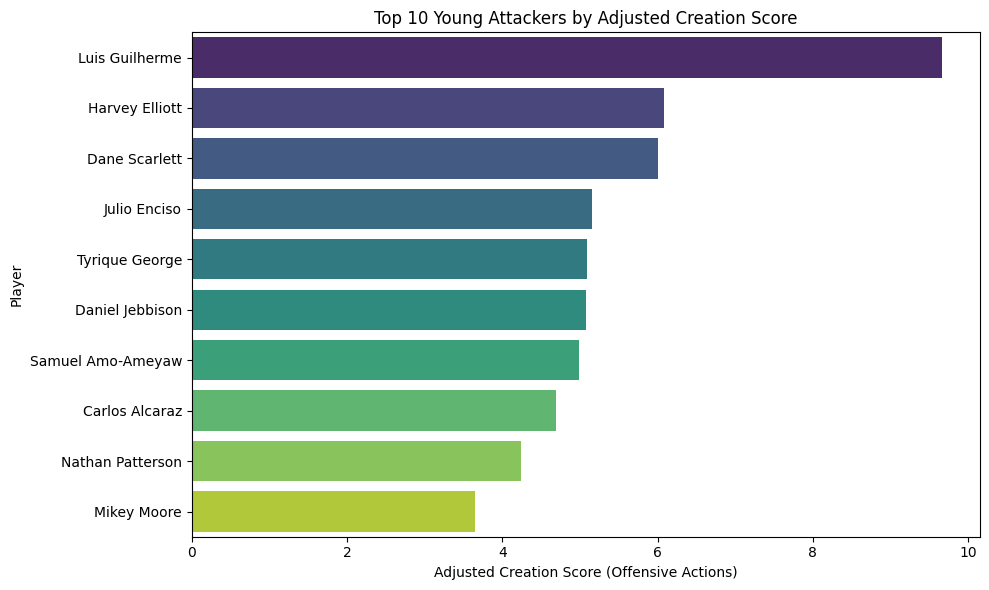

In [ ]:
# Step 13: Plot the top young forwards
plt.figure(figsize=(10, 6))
sns.barplot(x="adjusted_creation_score", y="player", data=top_attackers, palette="viridis")
plt.title("Top 10 Young Attackers by Adjusted Creation Score")
plt.xlabel("Adjusted Creation Score (Offensive Actions)")
plt.ylabel("Player")
plt.tight_layout()
plt.show()

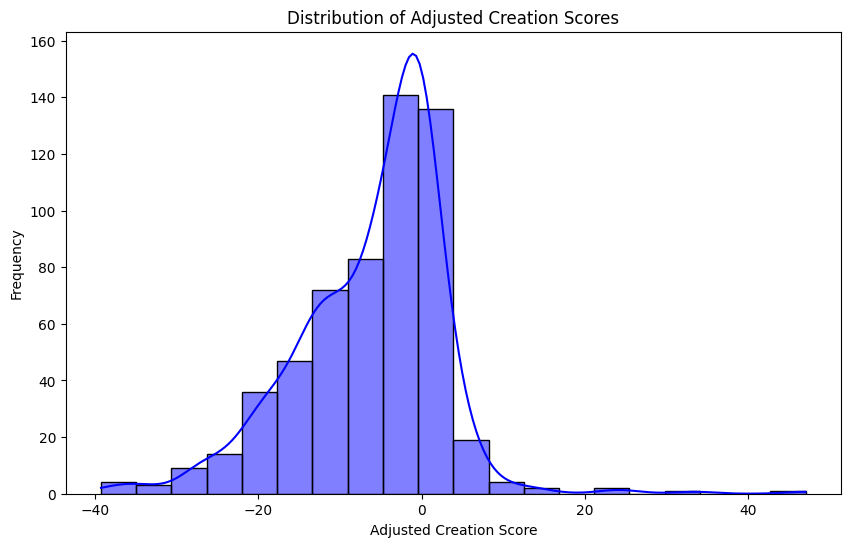

In [ ]:
# Step 14: Analyze distribution of creation scores
plt.figure(figsize=(10,6))
sns.histplot(player_creation_stats['adjusted_creation_score'].dropna(), bins=20, kde=True, color="blue")
plt.title("Distribution of Adjusted Creation Scores")
plt.xlabel("Adjusted Creation Score")
plt.ylabel("Frequency")
plt.show()

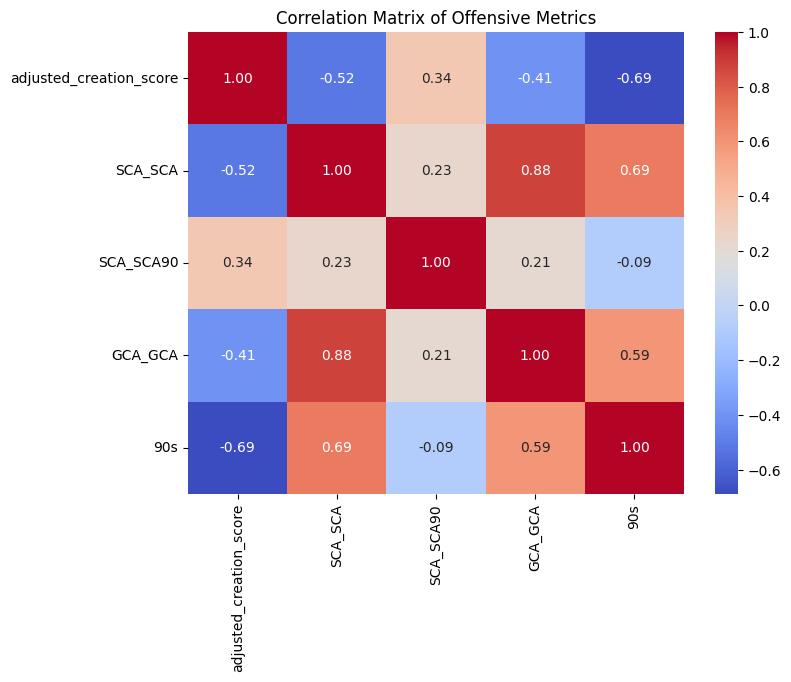

In [ ]:
# Step 15: Correlation heatmap
corr_matrix = player_creation_stats[['adjusted_creation_score', 'SCA_SCA', 'SCA_SCA90', 'GCA_GCA', '90s']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Offensive Metrics")
plt.show()

In [ ]:
!playwright install

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Ruta base donde están tus archivos en Google Drive
base_path = "/content/drive/My Drive/proyecto"

# Listar archivos dentro de la carpeta
files = os.listdir(base_path)
print("Archivos en la carpeta:", files)


Archivos en la carpeta: ['Primer-Avance-Proyecto-Integrador.gslides', 'merged_defensive_actions.csv', 'merged_defensive_actions.gsheet', 'Extracción-Transformación-Datos.ipynb', 'premier-league-stats-2023-2024.xlsx', 'Copy of Segundo-Avance.gdoc', 'defensas.ipynb', 'Segundo-Avance.gdoc', 'atacantes.pdf.pdf', 'defensas.pdf.pdf', 'Segundo-Avance-Proyecto-Integrador.gslides', 'Proyect-Final.gdoc', 'atacantes.ipynb', 'atacantes.html']


In [ ]:
!jupyter nbconvert --to webpdf /content/drive/My\Drive/proyecto/atacantes.ipynb --output "atacantes.pdf"

[NbConvertApp] Converting notebook /content/drive/MyDrive/proyecto/atacantes.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 316861 bytes to /content/drive/MyDrive/proyecto/atacantes.pdf.pdf
